In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("small degs large widths.csv")
#data = pd.read_csv("summary (48).csv")


# Get the substring in quotes
def get_substring_in_brackets(s):
    start = s.find('(') + 1
    end = s.rfind(')')
    return float(s[start:end])

data["val_loss"] = data["val_loss"].map(get_substring_in_brackets)
data["train_loss"] = data["train_loss"].map(get_substring_in_brackets)

print(data.columns)

Index(['deg', 'width', 'func', 'epoch', 'train_loss', 'val_loss', 'batch_size',
       'lr', 'n_samples', 'func_val_test', 'time_elapsed', 'backend',
       'top_eig', 'trace', 'stop_loss', 'ln_eps', 'ln', 'weight_norm', 'l',
       'd', 'f', 'h', 'dropout', 'wd'],
      dtype='object')


In [2]:
filtered_data = data.loc[data.groupby(["deg", "width", "func"])["epoch"].idxmax()]
print(filtered_data.shape)


(100, 24)


In [3]:
import math
from math import sqrt

perturbation_term = True
def L(omega, D_f, T):
    #bound = 21 + 16*(D_f+1)*D_f**2 + 8 * (D_f+1) + 4 * math.log(T)**2 * (D_f*omega + (T+1-omega))
    bound = 21 + 16*(D_f+1)*D_f**2 + 8 * (D_f+1) + 4 * math.log(T)**2 * (D_f*omega + (T))

    return sqrt(bound)

def G_p(sigma, omega, D_f, T, d):
    bound = 128 * sqrt(2) * sigma * D_f**2 * sqrt(omega) * math.log(T)
    bound += 192 * sigma * sqrt(omega) * D_f**2
    bound += 128 * sqrt(2) * D_f**2 * omega**2 * math.log(T)
    bound += 64 * sqrt(2) * d * D_f**2 * omega**2 * math.log(T)
    bound += 128 * sigma * d * omega**2 * math.log(T) * D_f * sqrt(D_f)
    bound += 1024 * sigma * D_f**3 * sqrt(D_f) * omega * sqrt(omega) * math.log(T)
    bound += 8 * sigma * sqrt(D_f) * sqrt(omega) * math.log(T) * d 
    bound += 256 * sigma * D_f**2 * sqrt(D_f) * omega**2 * d
    bound += 32 * sigma * sqrt(D_f) * omega**2 * d ** 2
    return bound

def H_u(omega, D_f, T, d):
    bound = 8*(D_f+1) + 6*(D_f+1)*math.sqrt(omega)
    bound += 2*math.sqrt(3*T*(D_f+1)) + math.sqrt(48*T*(D_f+1)*D_f)
    bound += math.sqrt(T)*math.sqrt(12*(D_f+1))*D_f
    bound += 2 * math.sqrt(T) * math.sqrt(12*(D_f+1)) * D_f
    bound += 8*math.sqrt(2)*math.sqrt(d*T)*D_f
    bound += 2*math.sqrt(d*T)*D_f
    bound += 8*math.sqrt(2)*d*D_f*math.sqrt(omega)
    bound += 6 * math.sqrt(2)*d*math.sqrt(d)*D_f
    return bound

def H_p(sigma, omega, D_f, T, d):
    bound = 768 * sqrt(2) * sigma * D_f**2 * omega * sqrt(omega) * d * math.log(T)
    bound += 256 * sigma * omega * sqrt(omega) * d**2 * D_f * sqrt(D_f) * math.log(T)
    bound += 1024 * sigma * D_f**3 * sqrt(D_f) * omega * sqrt(omega) * math.log(T)
    bound += 512 * sigma * D_f**2 * sqrt(D_f) * omega * sqrt(omega) * d**2 * math.log(T)
    bound += 1536 * sigma * D_f**3 * sqrt(D_f) * omega**2 * sqrt(omega) * sqrt(d) * math.log(T)**2
    bound += 768 * sigma * D_f**2 * omega**2 * sqrt(omega) * d * math.log(T)**2
    bound += 16 * sigma * omega**2 * d**2 * sqrt(d) * math.log(T)
    return bound

def G_u(omega, D_f):
    bound = 4 + 4*omega*(2 + D_f + 32*D_f**2 + 32*D_f**3)
    return bound

def T_p(sigma, omega, D_f, T, d):
    bound = 128 * sigma * D_f ** 2 * omega * math.log(T)
    bound += sigma * math.sqrt(2 * d) + 32 * math.sqrt(omega) * sigma * D_f ** 2
    return bound

def Theta(D_f, d):
    n = 3*(d+1)**2 + (d+1) + (8*d+6)*(D_f+1)
    return n

def P(sigma, omega, D_f, T, d): 
    pert_bound = 2*G_p(sigma, omega, D_f, T, d)*(2*math.sqrt(G_u(omega, D_f)) + G_p(sigma, omega, D_f, T, d))
    pert_bound += T_p(sigma, omega, D_f, T, d)*(H_u(omega, D_f, T, d) + H_p(sigma, omega, D_f, T, d)) * Theta(D_f, d)
    return pert_bound

def perturbed_sharpness_term(sigma, omega, D_f, T, d):
    if perturbation_term:
        trace_bound = G_u(omega, D_f) + P(sigma, omega, D_f, T, d)
    else:
        trace_bound = G_u(omega, D_f)

        
    return sigma**2 * trace_bound

def parameter_norm_term(Sigma, m, omega, D_f, T, sigma, delta, d):
    param_bound = 2 * sqrt( Sigma**2 / (2*m) * (L(omega, D_f, T)/(2*sigma**2) 
                                                + math.log(1/delta)))
    return param_bound

def theoretical_gen_gap(sigma, omega, D_f, T, Sigma, m, delta, d):
    #print("omega: " + str(omega) + ", D_f: " + str(D_f) + ", T: " + str(T))
    sharpness_term = perturbed_sharpness_term(sigma, omega, D_f, T, d)
    param_norm_term = parameter_norm_term(Sigma, m, omega, D_f, T, sigma, delta, d)
    return sharpness_term + param_norm_term

actual_gen_gap = filtered_data["actual_gen_gap"] = filtered_data["val_loss"] - filtered_data["train_loss"]


In [4]:
import numpy as np

# Create a mesh over T, D_f, omega
Ts = np.round(np.logspace(1, 4, num=5))
D_fs = np.round(np.logspace(.2, 1, num=10))
omegas = np.round(np.logspace(.2, 1.5, num=10))

print("omegas: " + str(omegas))

Ts, D_fs, omegas = np.meshgrid(Ts, D_fs, omegas, indexing='ij')
mesh_points = np.stack([Ts.ravel(), D_fs.ravel(), omegas.ravel()], axis=-1)

# Filter out points with D_f > T or omega > T
mesh_points = mesh_points[(mesh_points[:, 0] >= mesh_points[:, 1]) & (mesh_points[:, 0] >= mesh_points[:, 2])]

print("Mesh points:", mesh_points.shape)


# Add in points for out empirical construction
emp_Ts = [20]
emp_D_fs = [1, 2, 3, 4, 5]
#emp_D_fs = [1,1.5, 2,2.5, 3,3.5, 4,4.5, 5]
emp_omegas = [1,7,14,20]
#emp_omegas = range(1,20)
Ts, D_fs, omegas = np.meshgrid(emp_Ts, emp_D_fs, emp_omegas, indexing='ij')

emp_mesh_points = np.empty((20, 3))

i = 0
for T in emp_Ts:
    for D_f in emp_D_fs:
        for omega in emp_omegas:
            emp_mesh_points[i] = [T, D_f, omega]
            i += 1
            
mesh_points = np.concatenate([mesh_points, emp_mesh_points], axis=0)

print("Mesh and Empirical points:", mesh_points.shape)



omegas: [ 2.  2.  3.  4.  6.  8. 12. 16. 23. 32.]
Mesh points: (460, 3)
Mesh and Empirical points: (480, 3)


In [5]:
mesh_points

array([[10.,  2.,  2.],
       [10.,  2.,  2.],
       [10.,  2.,  3.],
       ...,
       [20.,  5.,  7.],
       [20.,  5., 14.],
       [20.,  5., 20.]])

In [6]:
from scipy.optimize import minimize, differential_evolution, curve_fit
from tqdm import tqdm
if perturbation_term:
    file_suffix = "_with_perturbation"
    startLogM = 6
    endLogM = 40
else:
    file_suffix = "_without_perturbation"
    startLogM = 1
    endLogM=7
delta = 0.2
Sigma = 0.01
load = False

if not load:
    records = []
    for row in tqdm(mesh_points): 
        for m in np.logspace(startLogM,endLogM, num=10):
            m=round(m)
            T, D_f, omega = row
            eps = 0.1
            #print("T: " + str(T))
            d = min(T,8*math.log(T)/(eps**2))
            # Mimimize over sigma
            minimal_bound = minimize(theoretical_gen_gap,
                                     x0=.001,
                                     args=(omega, D_f, T, Sigma, float(m), delta, d),
                                     bounds=[(1e-20, None)],
                                     options={'eps': 1e-10})
            #the below optimization gave a qualitatively similar result --  a choppy landscape for sigma -- but was way slower
            #minimal_bound = differential_evolution(theoretical_gen_gap, x0=0.1, args=(omega, D_f, T, Sigma, int(m), delta, d), bounds=[(0, 1)])
 
            records.append({
                "T": T,
                "D_f": D_f,
                "omega": omega,
                "m": m,
                "d": d,
                "delta": delta,
                "Sigma": Sigma,
                "sigma": minimal_bound.x[0],
                "bound": minimal_bound.fun
            })
            # if minimal_bound.fun <= 1:
            #     print(f"D_f: {D_f}, omega: {omega}, T: {T}, m: {m}, sigma: {minimal_bound.x[0]}, bound: {minimal_bound.fun}")
            #     #break ##for now, we calculate it for all ms we use
    sigma_data = pd.DataFrame(records)
    # Extract out unique rows
    sigma_data = sigma_data.drop_duplicates(subset=["T", "D_f", "omega", "m", "d", "delta", "Sigma", "sigma"])
    sigma_data_filtered = sigma_data[sigma_data["bound"] <= 1 & (sigma_data["sigma"] > 0)]
    # Group by D_f, omega, and T, then select the row with the minimal m
    non_vacuous = sigma_data_filtered.groupby(
        ["D_f", "omega", "T"], as_index=False
    ).agg({"m": "min"})

    # Merge the minimal m values back into the filtered DataFrame
    non_vacuous = sigma_data_filtered.merge(non_vacuous, 
                                         how="left",
                                         on=["D_f", "omega", "T"],
                                         suffixes=('_orig', '_min'))

    non_vacuous = non_vacuous[non_vacuous['m_min'] == non_vacuous['m_orig']]
    
    non_vacuous = non_vacuous.drop(columns=['m_orig'], axis=1)
    # Remove duplicate columns if necessary
    non_vacuous = non_vacuous.drop_duplicates(subset=['D_f', 'omega', 'T'], keep='first')

    print(sigma_data.shape)
    print(non_vacuous.shape)
    sigma_data.to_csv("optimized_sigma"+file_suffix+".csv", index=False)
    non_vacuous.to_csv(("non_vacous"+file_suffix+".csv"), index=False)
else:
    sigma_data=pd.read_csv("optimized_sigma"+file_suffix+".csv")
    non_vacuous=pd.read_csv(("non_vacous"+file_suffix+".csv"))

  0%|          | 0/480 [00:00<?, ?it/s]/var/folders/4c/b9h5j0n54y3d2236vqx5sqv40000gn/T/ipykernel_93520/1115832779.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  param_bound = 2 * sqrt( Sigma**2 / (2*m) * (L(omega, D_f, T)/(2*sigma**2)
100%|██████████| 480/480 [00:21<00:00, 21.93it/s]

(3070, 9)
(306, 9)


In [7]:

#non_vacuous = non_vacuous[non_vacuous["T"]==20]
# compute the maximum of these ms, to use in our theoretical bound plot
max_m = non_vacuous["m_min"].max()
print("max_m: " + str(max_m))
sigma_data["T"].unique()


max_m: 10000000000000000303786028427003666890752


array([   10.,    56.,   316.,  1778., 10000.,    20.])

In [8]:
test = sigma_data[sigma_data["T"]==316]
# min_sigma = sigma_data["sigma"].min()
# test[test["sigma"]==min_sigma]
test[test["bound"]<1]

,T,D_f,omega,m,d,delta,Sigma,sigma,bound
1609,316.0,2.0,2.0,10000000000000000303786028427003666890752,316.0,0.2,0.01,5.794064e-08,4.717398e-02
1628,316.0,2.0,3.0,1668100537200055593339245812959412224,316.0,0.2,0.01,3.358918e-08,8.025848e-02
1629,316.0,2.0,3.0,10000000000000000303786028427003666890752,316.0,0.2,0.01,1.513045e-08,1.628530e-02
1638,316.0,2.0,4.0,1668100537200055593339245812959412224,316.0,0.2,0.01,4.262415e-08,4.084652e-01
1639,316.0,2.0,4.0,10000000000000000303786028427003666890752,316.0,0.2,0.01,1.654095e-08,6.151266e-02
...,...,...,...,...,...,...,...,...,...
2569,316.0,10.0,12.0,10000000000000000303786028427003666890752,316.0,0.2,0.01,4.283815e-14,5.957962e-08
2579,316.0,10.0,16.0,10000000000000000303786028427003666890752,316.0,0.2,0.01,1.000000e-20,1.685908e-01
2589,316.0,10.0,23.0,10000000000000000303786028427003666890752,316.0,0.2,0.01,1.000000e-20,1.732348e-01
2598,316.0,10.0,32.0,1668100537200055593339245812959412224,316.0,0.2,0.01,8.205647e-12,3.875276e-02


In [9]:
unique_T_all = non_vacuous["T"].unique()
num_Ts = len(unique_T_all)
num_rows =num_Ts // 2+1
unique_T_all


array([   10.,    56.,   316.,  1778., 10000.,    20.])

In [10]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
unique_widths_all = non_vacuous["omega"].unique()
non_vacuous['logm'] = np.log(non_vacuous['m_min'].astype(float))
non_vacuous

fig = make_subplots(
    rows=num_rows, cols=2,
    specs=[
        [{"type": "xy"}]*2
    ]*num_rows,
    horizontal_spacing=0.10,
    vertical_spacing=0.10,
    subplot_titles=(unique_T_all)
)
for l, T in enumerate(unique_T_all):
    row = l//2+1
    col = l%2+1
    print("index: " + str(l) + ", row: "  + str(row) + ", col: " + str(col) + ", T: " + str(T))
    # Plot theo_gen_gap for each width
    for k, width in enumerate(unique_widths_all):
        #print("width: " + str(width))
        #print("non_vacuous: " + str(non_vacuous))
        subset = non_vacuous[non_vacuous["omega"] == width  ]
        #subset = sigma_data[(sigma_data["omega"] == width) &(sigma_data["m"]==max_m) ]
        
        #print("subset1: " + str(subset))
        subset = subset[subset["T"]==T]
        #print("subset: " + (str(subset)))
        fig.add_trace(
            #go.Scatter(x=subset["deg"], y=subset["theo_gen_gap"], mode='lines+markers', line=dict(color=colors[k]), showlegend=False),
            go.Scatter(x=subset["D_f"], y=subset["logm"], mode='lines+markers', showlegend=True),
            row=row, col=col            
        )
    
    fig.update_layout(
        title="log(m) for Non-Vacuous Bound by Degree, Width",
        height=750,
        width=1200,
        margin=dict(t=50, b=50, l=50, r=50)
    )
    
    fig.update_xaxes(title_text="Degree", row=row, col=col)
    fig.update_yaxes(title_text="Generalzation Gap", row=row, col=col)

fig.show()

index: 0, row: 1, col: 1, T: 10.0
index: 1, row: 1, col: 2, T: 56.0
index: 2, row: 2, col: 1, T: 316.0
index: 3, row: 2, col: 2, T: 1778.0
index: 4, row: 3, col: 1, T: 10000.0
index: 5, row: 3, col: 2, T: 20.0


         T  D_f  omega                                          m     d  \
4649  20.0  2.0    1.0  10000000000000000303786028427003666890752  20.0   
4659  20.0  2.0    7.0  10000000000000000303786028427003666890752  20.0   
4699  20.0  3.0    7.0  10000000000000000303786028427003666890752  20.0   
4709  20.0  3.0   14.0  10000000000000000303786028427003666890752  20.0   

      delta  Sigma         sigma     bound  
4649    0.2   0.01  6.770935e-07  0.000524  
4659    0.2   0.01  2.864343e-08  0.002243  
4699    0.2   0.01  1.960676e-08  0.005321  
4709    0.2   0.01  1.220669e-08  0.032998  
sigma shape: (20,)
D_f mesh shape: (4, 5), omega mesh shape: (4, 5)


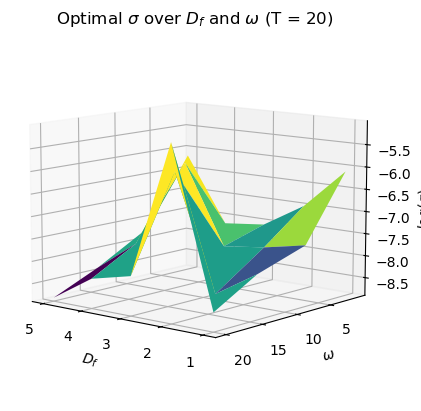

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

T_fixed = 20
df = sigma_data[sigma_data["m"]==max_m]
#df = df[df["D_f"]<=5]

#df = non_vacuous
# Filter the DataFrame for the fixed T
df_fixed = df[df['T'] == T_fixed]
#print("df_fixed shape: " + ))
# Extract D_f, omega, and sigma values for the plot
print(df_fixed[((df_fixed['D_f']==2)&(df_fixed['omega']==1))|
      ((df_fixed['D_f']==2)&(df_fixed['omega']==7)) |
      ((df_fixed['D_f']==3)&(df_fixed['omega']==7))  |
      ((df_fixed['D_f']==3)&(df_fixed['omega']==14))])

D_f = df_fixed['D_f']
omega = df_fixed['omega']
sigma = df_fixed['sigma']
print("sigma shape: " + str(sigma.shape))
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for the surface plot
D_f_mesh, omega_mesh = np.meshgrid(np.unique(D_f), np.unique(omega))
print("D_f mesh shape: " + str(D_f_mesh.shape)+", omega mesh shape: " + str(omega_mesh.shape))
# Plot the surface
ax.plot_surface(D_f_mesh, omega_mesh, np.reshape(np.log10(sigma), (D_f_mesh.shape)), cmap='viridis')

# Set labels and title
ax.set_xlabel('$D_f$')
ax.set_ylabel('$\omega$')
ax.set_zlabel('$log(\sigma)$')
ax.set_title(f'Optimal $\sigma$ over $D_f$ and $\omega$ (T = {T_fixed})')
ax.view_init(elev=10, azim=130, roll=0)

# Display the plot

plt.savefig("surface_plot.png")


/var/folders/4c/b9h5j0n54y3d2236vqx5sqv40000gn/T/ipykernel_93520/3956606771.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



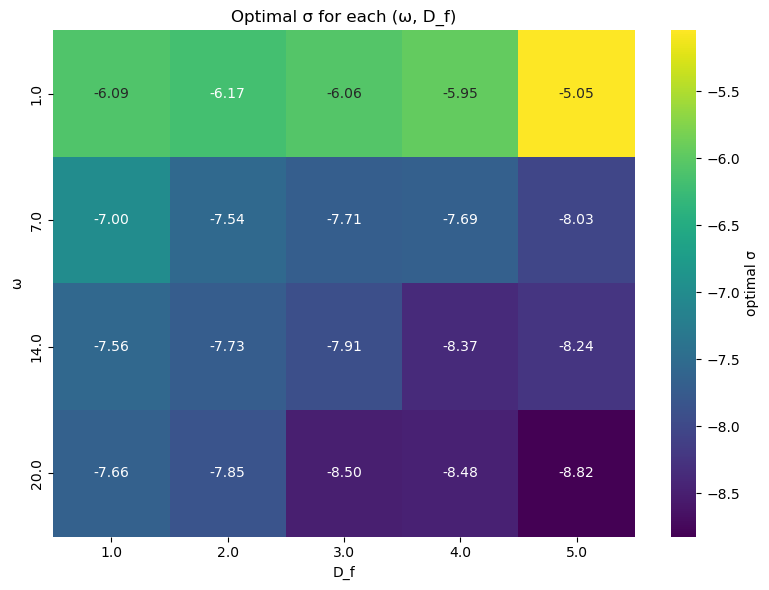

In [12]:
df_fixed["log_sigma"] = np.log10(df_fixed["sigma"])
# assume your DataFrame is called df, with columns ["omega","D_f","sigma",…]
pivot = df_fixed.pivot(index="omega", columns="D_f", values="log_sigma")

plt.figure(figsize=(8,6))
sns.heatmap(
    pivot,
    annot=True,        # show the numbers in each cell
    fmt=".2f",         # format for the numbers
    cmap="viridis",    # or any other seaborn/matplotlib colormap
    cbar_kws={"label":"optimal σ"}
)
plt.title("Optimal σ for each (ω, D_f)")
plt.xlabel("D_f")
plt.ylabel("ω")
plt.tight_layout()
plt.show()

In [13]:
filtered_data["width"].unique()

array([ 1,  7, 14, 20])

In [469]:
non_vacuous

,T,D_f,omega,d,delta,Sigma,sigma,bound,m_min,logm
0,10.0,2.0,2.0,10.0,0.2,0.01,5.562629e-06,0.210977,5994842503,22.514165
9,10.0,2.0,3.0,10.0,0.2,0.01,5.562629e-06,0.616172,5994842503,22.514165
17,10.0,2.0,4.0,10.0,0.2,0.01,4.219902e-06,0.913316,278255940220711437037622788096000,74.706094
20,10.0,2.0,5.0,10.0,0.2,0.01,2.540161e-07,0.008077,10000000000000000303786028427003666890752,92.103404
21,10.0,2.0,7.0,10.0,0.2,0.01,1.171398e-06,0.659665,1668100537200055593339245812959412224,83.404749
...,...,...,...,...,...,...,...,...,...,...
370,20.0,4.0,20.0,20.0,0.2,0.01,1.000000e-20,0.083797,10000000000000000303786028427003666890752,92.103404
371,20.0,5.0,1.0,20.0,0.2,0.01,3.458272e-06,0.532977,7742636826811277720420352,57.308785
375,20.0,5.0,7.0,20.0,0.2,0.01,1.368671e-08,0.020007,10000000000000000303786028427003666890752,92.103404
376,20.0,5.0,14.0,20.0,0.2,0.01,1.000000e-20,0.086889,10000000000000000303786028427003666890752,92.103404


In [499]:
filtered_data

,deg,width,func,epoch,train_loss,val_loss,batch_size,lr,n_samples,func_val_test,...,d,f,h,dropout,wd,actual_gen_gap,theo_gen_gap,unperturbed_gradient_term,perturbed_hessian_term,sigma
1403,2,1,1,91,0.0049,0.0050,64,0.0004,8192,tensor([0.]),...,200,128,1,0.2,0.01,0.0001,1.607154e+04,1556,1.142471e+09,2.842348e-06
3184,2,1,2,96,0.0049,0.0046,64,0.0004,8192,tensor([0.]),...,200,128,1,0.2,0.01,-0.0003,1.607154e+04,1556,1.142471e+09,2.842348e-06
3620,2,1,3,125,0.0032,0.0029,64,0.0004,8192,tensor([0.]),...,200,128,1,0.2,0.01,-0.0003,1.607154e+04,1556,1.142471e+09,2.842348e-06
5995,2,1,4,120,0.0043,0.0046,64,0.0004,8192,tensor([0.]),...,200,128,1,0.2,0.01,0.0003,1.607154e+04,1556,1.142471e+09,2.842348e-06
6567,2,1,5,103,0.0044,0.0039,64,0.0004,8192,tensor([0.]),...,200,128,1,0.2,0.01,-0.0005,1.607154e+04,1556,1.142471e+09,2.842348e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,5,20,1,199800,0.0120,0.0459,64,0.0004,8192,tensor([-0.7434]),...,200,128,1,0.2,0.01,0.0339,8.543048e+10,384564,7.116727e+15,1.000000e-20
1799,5,20,2,77384,0.0049,0.0228,64,0.0004,8192,tensor([-0.6261]),...,200,128,1,0.2,0.01,0.0179,8.543048e+10,384564,7.116727e+15,1.000000e-20
3358,5,20,3,32953,0.0049,0.0256,64,0.0004,8192,tensor([0.4538]),...,200,128,1,0.2,0.01,0.0207,8.543048e+10,384564,7.116727e+15,1.000000e-20
4628,5,20,4,199800,0.0083,0.0343,64,0.0004,8192,tensor([-0.4846]),...,200,128,1,0.2,0.01,0.0260,8.543048e+10,384564,7.116727e+15,1.000000e-20


In [14]:
filtered_data = filtered_data[filtered_data["deg"]!=1]

fig = make_subplots(
    rows=1, cols=2,
    specs=[
        [{"type": "xy"}, {"type": "xy"}]
    ],
    horizontal_spacing=0.10,
    vertical_spacing=0.10,
    subplot_titles=("Theoretical", "Empirical")
)
T = 20

# Get unique widths
#unique_widths = filtered_data["width"].unique()
unique_widths = sigma_data[sigma_data["T"]==T]["omega"].unique()
print("unique_widths: " + str(unique_widths))
colors = ["red", "brown", "green", "purple"]

max_m = non_vacuous[non_vacuous["T"]==20]["m_min"].max()
print("max_m: " + str(max_m))
sigma_data["T"].unique()

delta = 0.2
Sigma = 0.01
eps = 0.1
d = min(T,8*math.log(T)/eps**2)
optimize_each_sigma = False

max_m=1e15
max_m = float(max_m)
def fetch_optimal_sigma(row):
    # Fetch optimal sigma for each width
    print("omega: " + str(row["width"]) + ", D_f: " + str(row["deg"]) + ", T: " + str(T))

    return sigma_data[(sigma_data["T"] == T) & 
                      (sigma_data["omega"] == row["width"]) & 
                      (sigma_data["D_f"] == row["deg"])]["sigma"].values[-1]

    
if optimize_each_sigma:
# Fetch optimal theo_gen_gap for each width
    filtered_data["theo_gen_gap"] = filtered_data.apply(
        lambda row: theoretical_gen_gap(
            sigma=fetch_optimal_sigma(row),
            omega=row["width"],
            D_f=row["deg"],
            T=T,
            Sigma=Sigma,
            m = max_m,
            delta=delta,
            d = d
        ), axis=1)
    filtered_data["unperturbed_gradient_term"]= filtered_data.apply(
        lambda row: G_u(omega=row["width"],D_f = row["deg"]), axis=1)
    filtered_data["perturbed_hessian_term"]= filtered_data.apply(
        lambda row: P(sigma = fetch_optimal_sigma(row), omega=row["width"],D_f = row["deg"],T=T,d=d), axis=1)
    filtered_data["sigma"]= filtered_data.apply(
        lambda row: fetch_optimal_sigma(row), axis=1)
else:    
    
    # get the last (i.e. optimal) sigma for each (omega, D_f)
    last_per_combo = (
        sigma_sub
        .groupby(["omega", "D_f"], observed=True)["sigma"]
        .last()
    )
    print("last_per_combo: " + str(last_per_combo))
    # compute the overall average of those optimal sigmas
    #mean_sigma = last_per_combo.min()
    #print("mean sigma: " + str(mean_sigma))
    mean_sigma = 1e-8

    
    # now plug this constant mean_sigma into your theo_gen_gap computation:
    filtered_data["theo_gen_gap"] = filtered_data.apply(
        lambda row: theoretical_gen_gap(
            sigma = mean_sigma,
            omega = row["width"],
            D_f   = row["deg"],
            T     = T,
            Sigma = Sigma,
            m     = max_m,
            delta = delta,
            d     = d
        ),
        axis=1
    )

# Plot theo_gen_gap for each width
for k, width in enumerate(unique_widths):
    #print("width: " + str(width))
    subset = filtered_data[filtered_data["width"] == width]
    #print("subset: " + (str(subset)))
    fig.add_trace(
        #go.Scatter(x=subset["deg"], y=(subset["sigma"]**2)*(subset["perturbed_hessian_term"]+subset["unperturbed_gradient_term"]), mode='lines+markers', line=dict(color=colors[k]), showlegend=False),
        go.Scatter(x=subset["deg"], y=subset["theo_gen_gap"], mode='lines+markers', line=dict(color=colors[k]), showlegend=False),
        #go.Scatter(x=subset["deg"], y=subset["theo_gen_gap"], mode='lines+markers', showlegend=False),

        row=1, col=1
    )

# Plot actual_gen_gap for each width, averaging over func
for k, width in enumerate(unique_widths):
    subset = filtered_data[filtered_data["width"] == width]
    avg_actual_gen_gap = subset.groupby("deg")["actual_gen_gap"].mean()
    fig.add_trace(
        go.Scatter(x=avg_actual_gen_gap.index, y=avg_actual_gen_gap.values, mode='lines+markers', line=dict(color=colors[k]), name=f"Width={width}"),
        #go.Scatter(x=avg_actual_gen_gap.index, y=avg_actual_gen_gap.values, mode='lines+markers', name=f"Width={width}"),
        row=1, col=2
    )
fig.update_layout(
    title={
            'text' : f'Comparison of Empirical and Theoretical Generalization Gap by Degree, width (m={"{:.1e}".format(max_m)})',
            'x':0.5,
            'xanchor': 'center'
        },
    height=750,
    width=1200,
    margin=dict(t=50, b=50, l=50, r=50)
)
fig.update_xaxes(title_text="Degree", row=1, col=3)
fig.update_xaxes(title_text="Degree", row=2, col=1)
fig.update_xaxes(title_text="Degree", row=2, col=2)
fig.update_yaxes(title_text="Generalzation Gap", row=1, col=1)
fig.update_yaxes(title_text="Generalzation Gap", row=1, col=3)
fig.update_yaxes(title_text="Generalzation Gap", row=2, col=1)
fig.show()
fig.write_image("plots/unperturbed vary over sigma.png", width=1200, height=750)

unique_widths: [ 1.  7. 14. 20.]
max_m: 10000000000000000303786028427003666890752


NameError: name 'sigma_sub' is not defined

In [473]:
sigma_data[(sigma_data["T"] == 56) &  (sigma_data["omega"] == 1) & (sigma_data["D_f"] == 2)]["sigma"]

,T,D_f,omega,m,d,delta,Sigma,sigma,bound
1000,56.0,2.0,2.0,1000000,56.0,0.2,0.01,5.595516e-06,21.484104
1001,56.0,2.0,2.0,5994842503,56.0,0.2,0.01,5.570965e-06,7.284084
1002,56.0,2.0,2.0,35938136638046,56.0,0.2,0.01,5.579312e-06,7.121964
1003,56.0,2.0,2.0,215443469003187776,56.0,0.2,0.01,5.587667e-06,7.140938
1004,56.0,2.0,2.0,1291549665014882762752,56.0,0.2,0.01,5.604105e-06,7.182986
...,...,...,...,...,...,...,...,...,...
1095,56.0,2.0,10.0,7742636826811277720420352,56.0,0.2,0.01,4.582356e-06,3000.606808
1096,56.0,2.0,10.0,46415888336127532003175170048,56.0,0.2,0.01,5.248541e-06,3936.506219
1097,56.0,2.0,10.0,278255940220711437037622788096000,56.0,0.2,0.01,1.198497e-06,205.255123
1098,56.0,2.0,10.0,1668100537200055593339245812959412224,56.0,0.2,0.01,1.652508e-07,3.902151


In [27]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sigmas = [ 1e-8, 1e-7, 1e-6,  1e-5]
pos = [(1, 1), (1, 2), (2, 1), (2, 2)]
fig = make_subplots(
    rows=2, cols=3,
    specs=[
        [{"type": "xy"}, {"type": "xy"}, {"rowspan": 2, "colspan": 1}],  # First row
        [{"type": "xy"}, {"type": "xy"}, None]                           # Second row
    ],
    column_widths=[0.25, 0.25, 0.5],  # Left half = 0.25+0.25, Right = 0.5
    row_heights=[0.5, 0.5],
    horizontal_spacing=0.10,
    vertical_spacing=0.10,
    subplot_titles=(f"σ = {sigmas[0]}", f"σ = {sigmas[1]}", "Empirical Generalization Gap", f"σ = {sigmas[2]}", f"σ = {sigmas[3]}")
)

# Get unique widths
unique_widths = filtered_data["width"].unique()
colors = ["red", "brown", "green", "purple"]

T = 20
delta = 0.2
Sigma = 0.01
d = min(T,8*np.log(T)/(eps**2))
# eps = 0.01
# d = 8*math.log(T)/eps**2

# T, D_f, m, omega 

for i, sigma in enumerate(sigmas): 
    # Plot theo_gen_gap for each width
    filtered_data["theo_gen_gap"] = filtered_data.apply(
    lambda row: theoretical_gen_gap(
        sigma=sigma,
        omega=row["width"],
        D_f=row["deg"],
        T=T,
        Sigma=Sigma,
        m=max_m,
        delta=delta,
        d=d
    ),
    axis=1)
    for k, width in enumerate(unique_widths):
        subset = filtered_data[filtered_data["width"] == width]
        fig.add_trace(
            go.Scatter(x=subset["deg"], y=subset["theo_gen_gap"], mode='lines+markers', line=dict(color=colors[k]), showlegend=False),
            row=pos[i][0], col=pos[i][1]
        )

# Plot actual_gen_gap for each width, averaging over func
for k, width in enumerate(unique_widths):
    subset = filtered_data[filtered_data["width"] == width]
    avg_actual_gen_gap_mean = subset.groupby("deg")["actual_gen_gap"].mean()
    avg_actual_gen_gap_std = subset.groupby("deg")["actual_gen_gap"].std()

    fig.add_trace(
        go.Scatter(x=avg_actual_gen_gap.index, y=avg_actual_gen_gap_mean.values, error_y=dict(
            array = avg_actual_gen_gap_std.values,),
            mode='lines+markers', line=dict(color=colors[k]), name=f"Width={width}"),
        row=1, col=3
    )

fig.update_layout(
    title={
            'text' : f'Comparison of Empirical and Theoretical Generalization Gap by Degree, width (m={"{:.1e}".format(max_m)})',
            'x':0.5,
            'xanchor': 'center'
        },
    height=750,
    width=1200,
    margin=dict(t=50, b=50, l=50, r=50)
)
fig.update_xaxes(title_text="Degree", row=1, col=3)
fig.update_xaxes(title_text="Degree", row=2, col=1)
fig.update_xaxes(title_text="Degree", row=2, col=2)
fig.update_yaxes(title_text="Generalzation Gap", row=1, col=1)
fig.update_yaxes(title_text="Generalzation Gap", row=1, col=3)
fig.update_yaxes(title_text="Generalzation Gap", row=2, col=1)
fig.show()
fig.write_image("plots/unpretrubed vary over sigma.png", width=1200, height=750)



In [32]:
filtered_data = filtered_data[filtered_data["deg"]!=1]

fig = make_subplots(
    rows=1, cols=2,
    specs=[
        [{"type": "xy"}, {"type": "xy"}]
    ],
    horizontal_spacing=0.10,
    vertical_spacing=0.10,
    subplot_titles=("Theoretical", "Empirical")
)
T = 56

# Get unique widths
#unique_widths = filtered_data["width"].unique()
unique_widths = sigma_data[sigma_data["T"]==T]["omega"].unique()
print("unique_widths: " + str(unique_widths))
colors = ["red", "brown", "green", "purple"]

delta = 0.2
Sigma = 0.01
eps = 0.1
d = min(T,8*math.log(T)/eps**2)
optimize_each_sigma = True


def fetch_optimal_sigma(row):
    # Fetch optimal sigma for each width
    print("omega: " + str(row["width"]) + ", D_f: " + str(row["deg"]) + ", T: " + str(T))

    return sigma_data[(sigma_data["T"] == T) & 
                      (sigma_data["omega"] == row["width"]) & 
                      (sigma_data["D_f"] == row["deg"])]["sigma"].values[-1]

    
if optimize_each_sigma:
# Fetch optimal theo_gen_gap for each width
    sigma_data["theo_gen_gap"] = filtered_data.apply(
        lambda row: theoretical_gen_gap(
            sigma=fetch_optimal_sigma(row),
            omega=row["width"],
            D_f=row["deg"],
            T=T,
            Sigma=Sigma,
            m = max_m,
            delta=delta,
            d = d
        ), axis=1)
    filtered_data["unperturbed_gradient_term"]= filtered_data.apply(
        lambda row: G_u(omega=row["width"],D_f = row["deg"]), axis=1)
    filtered_data["perturbed_hessian_term"]= filtered_data.apply(
        lambda row: P(sigma = fetch_optimal_sigma(row), omega=row["width"],D_f = row["deg"],T=T,d=d), axis=1)
    filtered_data["sigma"]= filtered_data.apply(
        lambda row: fetch_optimal_sigma(row), axis=1)
else:    
    
    # get the last (i.e. optimal) sigma for each (omega, D_f)
    last_per_combo = (
        sigma_sub
        .groupby(["omega", "D_f"], observed=True)["sigma"]
        .last()
    )
    print("last_per_combo: " + str(last_per_combo))
    # compute the overall average of those optimal sigmas
    mean_sigma = last_per_combo.min()

    
    # now plug this constant mean_sigma into your theo_gen_gap computation:
    filtered_data["theo_gen_gap"] = filtered_data.apply(
        lambda row: theoretical_gen_gap(
            sigma = mean_sigma,
            omega = row["width"],
            D_f   = row["deg"],
            T     = T,
            Sigma = Sigma,
            m     = max_m,
            delta = delta,
            d     = d
        ),
        axis=1
    )

# Plot theo_gen_gap for each width
for k, width in enumerate(unique_widths):
    #print("width: " + str(width))
    subset = filtered_data[filtered_data["width"] == width]
    #print("subset: " + (str(subset)))
    fig.add_trace(
        #go.Scatter(x=subset["deg"], y=(subset["sigma"]**2)*(subset["perturbed_hessian_term"]+subset["unperturbed_gradient_term"]), mode='lines+markers', line=dict(color=colors[k]), showlegend=False),
        go.Scatter(x=subset["deg"], y=subset["theo_gen_gap"], mode='lines+markers', line=dict(color=colors[k]), showlegend=False),
        #go.Scatter(x=subset["deg"], y=subset["theo_gen_gap"], mode='lines+markers', showlegend=False),

        row=1, col=1
    )

# Plot actual_gen_gap for each width, averaging over func
for k, width in enumerate(unique_widths):
    subset = filtered_data[filtered_data["width"] == width]
    avg_actual_gen_gap = subset.groupby("deg")["actual_gen_gap"].mean()
    fig.add_trace(
        go.Scatter(x=avg_actual_gen_gap.index, y=avg_actual_gen_gap.values, mode='lines+markers', line=dict(color=colors[k]), name=f"Width={width}"),
        #go.Scatter(x=avg_actual_gen_gap.index, y=avg_actual_gen_gap.values, mode='lines+markers', name=f"Width={width}"),
        row=1, col=2
    )
fig.update_layout(
    title="Comparison of Empirical and Theoretical Generalization Gap by Degree, Width",
    height=750,
    width=1200,
    margin=dict(t=50, b=50, l=50, r=50)
)
fig.update_xaxes(title_text="Degree", row=1, col=3)
fig.update_xaxes(title_text="Degree", row=2, col=1)
fig.update_xaxes(title_text="Degree", row=2, col=2)
fig.update_yaxes(title_text="Generalzation Gap", row=1, col=1)
fig.update_yaxes(title_text="Generalzation Gap", row=1, col=3)
fig.update_yaxes(title_text="Generalzation Gap", row=2, col=1)
fig.show()
fig.write_image("plots/unperturbed vary over sigma.png", width=1200, height=750)